#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [12]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [5]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

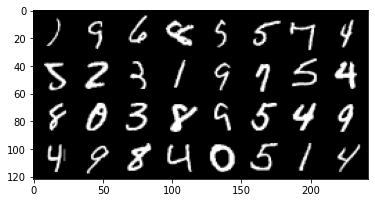

        1         9         6         8


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [14]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

[1,   100] loss: 1.373
[1,   200] loss: 0.506
[1,   300] loss: 0.387
[1,   400] loss: 0.380
[1,   500] loss: 0.328
[1,   600] loss: 0.346
[1,   700] loss: 0.309
[1,   800] loss: 0.284
[1,   900] loss: 0.287
[1,  1000] loss: 0.248
[1,  1100] loss: 0.269
[1,  1200] loss: 0.243
[1,  1300] loss: 0.245
[1,  1400] loss: 0.238
[1,  1500] loss: 0.201
[1,  1600] loss: 0.223
[1,  1700] loss: 0.214
[1,  1800] loss: 0.209


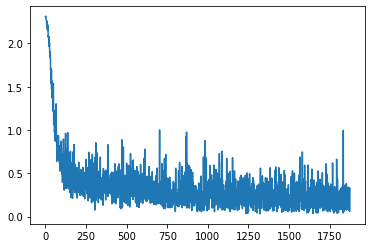

In [10]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

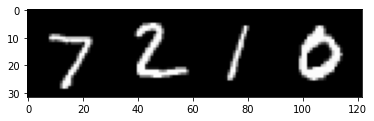

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [11]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [16]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [13]:
print("Current accuracy: %f" % accuracy(net, data['train']))

Current accuracy: 0.950867


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [14]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

0.9509 0.9483 0.8955


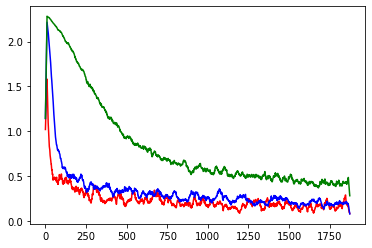

In [15]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

Increasing the momentum to a value higher than 0.9 seems to really decrease the accuracy and make it hard for the model to converge (the loss plot bounces all over the place). The convergence doesn't seem very  affected as long as the momentum value is under 1 (the graph looks very similar for 0.9, 0.6, and 0.01), although greater higher momentum values seem to converge faster than lower momentum values. Changing momentum doesn't seem to affect accuracy very much, since the difference between the test and training accuracies of having 0.9, 0.7, 0.6, 0.5, 0.1, 0.05, 0.01, and 0.0 momentum is only about 1-2%. From our tests below, we found that 0.6 momentum resulted in the highest test accuracy of 0.9601.

After running these tests several times, I found that any momentum within 0.9-0.1 range popped up as the most accurate. This fits with what we learned in class, which is that the value of momentum doesn't seem to matter as long as we have some momentum. 

In [52]:
#TODO: Write your code here for experimenting with different values of momentum.
for m in [1.5, 1, 0.9, 0.7, 0.6, 0.5, 0.1, 0.05, 0.01, 0.0]:
  print("Now trying momentum = %f" % m)
  net = SimpleNet()
  train(net, data['train'], lr=.1, momentum=0.9, verbose=0)
  print("Training accuracy: %f" % accuracy(net, data['train']))
  print("Test accuracy: %f \n" % accuracy(net, data['test']))

Now trying momentum = 1.500000
Training accuracy: 0.950383
Test accuracy: 0.945000 

Now trying momentum = 1.000000
Training accuracy: 0.954750
Test accuracy: 0.948800 

Now trying momentum = 0.900000
Training accuracy: 0.956650
Test accuracy: 0.952000 

Now trying momentum = 0.700000
Training accuracy: 0.958133
Test accuracy: 0.954300 

Now trying momentum = 0.600000
Training accuracy: 0.963667
Test accuracy: 0.960100 

Now trying momentum = 0.500000
Training accuracy: 0.956633
Test accuracy: 0.951800 

Now trying momentum = 0.100000
Training accuracy: 0.964317
Test accuracy: 0.959100 

Now trying momentum = 0.050000
Training accuracy: 0.962400
Test accuracy: 0.956600 

Now trying momentum = 0.010000
Training accuracy: 0.963817
Test accuracy: 0.959100 

Now trying momentum = 0.000000
Training accuracy: 0.952950
Test accuracy: 0.950700 



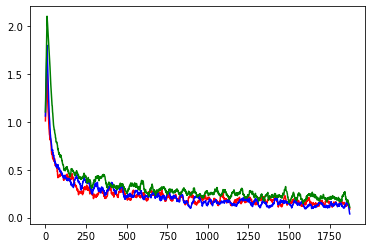

In [53]:
# Test momentum convergence < 1
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.9, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')

net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.1, momentum=0.6, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')

net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.1, momentum=0.01, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

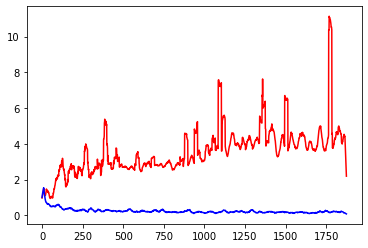

In [28]:
# Plot momentum convergence > 1
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')

net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.1, momentum=0.9, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

Our current model seems to overfit the training data a little bit since the training accuracy is greater than the test accuracy. However, the difference is very small (< 1% for 0.6 momentum and 0.1 learning rate), so it may have just been due to the noise in the data. To investigate this further, we would probably have to do some statistical tests and try training/testing on different samples of our data to see whether the 1% gap was consistent.

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

I tried out many values for weight decay (0.5, 0.1, 0.05, 0.01, 0.0) and found that lower decay results in higher final accuracy (actually, having 0 decay resulted in the highest training and test accuracy). In terms of convergence, having a higher weight decay seems to make the model converge earlier, although both 0.1 and 0.05 weight decay values experienced a drop in loss at the end after seemingly converging.

I expected higher values of weight decay to cause the accuracy to go down because it would regularize the model too much, cause the weights to be too small, and generally not fit the data well. However, I was surprised to find that having 0 weight decay resulted in the highest accuracy - I thought that having no weight decay would result in overfitting and a lower test accuracy.


In [54]:
#TODO: Write your code here for experimenting with different weight decay
for d in [0.5, 0.1, 0.05, 0.01, 0.0]:
  print("Now trying decay = %f" % d)
  net = SimpleNet()
  train(net, data['train'], lr=.1, momentum=0.6, decay=d, verbose=0)
  print("Training accuracy: %f" % accuracy(net, data['train']))
  print("Test accuracy: %f \n" % accuracy(net, data['test']))

Now trying decay = 0.500000
Training accuracy: 0.115400
Test accuracy: 0.116900 

Now trying decay = 0.100000
Training accuracy: 0.789850
Test accuracy: 0.795100 

Now trying decay = 0.050000
Training accuracy: 0.858700
Test accuracy: 0.864600 

Now trying decay = 0.010000
Training accuracy: 0.914817
Test accuracy: 0.917500 

Now trying decay = 0.000000
Training accuracy: 0.966900
Test accuracy: 0.964400 



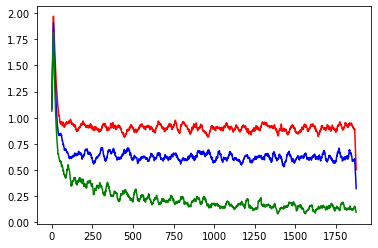

In [57]:
# Test decay convergence < 1
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.6, decay=0.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')

net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.1, momentum=0.6, decay=0.05, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')

net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.1, momentum=0.6, decay=0, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

In class, it was mentioned that generally more layers is better because the you can represent more complex functions with it. I added another layer to make it a 4 layer network because I wanted to do more feature extraction so that we could better represent the function. To figure out the number of neurons, I started with 512 and tested one factor of 2 greater and one factor of 2 less than it (256 and 1024). Using the original hyperparameters (learning rate = 0.01, momentum = 0.9, and decay = 0), I found that having 4 layers, no matter what combination of number of neurons (256, 512, 1024) I had in each layer, the training and test accuracies were higher than the 3 layer network with the same hyperparameters.

I found that the most accurate combination of neurons in layers was to have 1024 in each hidden layer (resulted in the highest test and training accuracy). Thus, I avoided adding a third additional hidden layer because I wanted to keep the number of connections below 2000000 and maintain the number of neurons in my hidden layers.

For activation functions, I chose to use the leaky ReLU because we will never be stuck in a situation where we have very small gradients (since leaky ReLU is not saturated in any particular direction). This means we will always be able to make significant updates to our weights and biases.

For loss function, I tried 2 different ones that we've learned about for classification tasks (cross entropy and negative log likelihood). I found that cross entropy loss produces the best training and test accuracy, which makes sense since cross entropy loss is very similar to NLL except that it penalizes confident but wrong predictions and correct but less confident predictions.

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

I experimented with the learning rate, momentum, and weight decay. Starting with the learning rate, I discovered that 0.01 produced the best test accuracy of 95.9% (out of 0.5, 0.1, 0.05, 0.01). Using this learning rate, I then tried to find the optimal momentum out of 0.9, 0.7, 0.6, 0.5, 0.1, 0.05, 0.01, and 0.0. The optimum momentum turned out to be 0.9, which resulted in a test accuracy of 95.8%. I then tested out several weight decays (0.5, 0.1, 0.05, 0.01, 0.0) and found that having 0 decay produced the highest test accuracy of 94.9%. 

When I trained with the default hyperparameters (learning rate = 0.01, momentum = 0.9, and decay = 0), the neural network produced an accuracy of 96%. Interestingly, after I optimized all my hyperparameters through the process described above, I ended up with a lower accuracy of 94.9%. Thus, the default hyperparameters are actually better than the hyperparameters I discovered through my trials.

Because my training accuracy is higher than my test accuracy, my model was likely overfitting the data. However, the differece between the accuracies was very small (< 1%) so it may have just been due to the noise in the data. To investigate this further, we would likely have to do some statistical tests and try training/testing on different samples of our data.

In [6]:
#TODO: Write your new model and experiments here
class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self, inputs=28*28, hidden1=1024, hidden2=1024, outputs=10):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x

In [50]:
# SimpleNet for comparison
net = SimpleNet()
train(net, data['train'], verbose=0)
print("Training accuracy: %f" % accuracy(net, data['train']))
print("Test accuracy: %f \n" % accuracy(net, data['test']))

Training accuracy: 0.950017
Test accuracy: 0.948600 



In [49]:
# Hidden layer neuron tests
layer1 = [256, 512, 1024]
layer2 = layer1
for h1 in layer1:
  for h2 in layer2:
    print("Layer structure: 784 -> %d -> %d -> 10" % (h1, h2))
    net = ExperiNet(hidden1=h1, hidden2=h2)
    train(net, data['train'], verbose=0)
    print("Training accuracy: %f" % accuracy(net, data['train']))
    print("Test accuracy: %f \n" % accuracy(net, data['test']))

Layer structure: 784 -> 256 -> 256 -> 10
Training accuracy: 0.956683
Test accuracy: 0.956200 

Layer structure: 784 -> 256 -> 512 -> 10
Training accuracy: 0.956017
Test accuracy: 0.953100 

Layer structure: 784 -> 256 -> 1024 -> 10
Training accuracy: 0.955217
Test accuracy: 0.953600 

Layer structure: 784 -> 512 -> 256 -> 10
Training accuracy: 0.958083
Test accuracy: 0.957100 

Layer structure: 784 -> 512 -> 512 -> 10
Training accuracy: 0.957317
Test accuracy: 0.955200 

Layer structure: 784 -> 512 -> 1024 -> 10
Training accuracy: 0.959717
Test accuracy: 0.957100 

Layer structure: 784 -> 1024 -> 256 -> 10
Training accuracy: 0.960633
Test accuracy: 0.956400 

Layer structure: 784 -> 1024 -> 512 -> 10
Training accuracy: 0.960067
Test accuracy: 0.958000 

Layer structure: 784 -> 1024 -> 1024 -> 10
Training accuracy: 0.962483
Test accuracy: 0.961100 



In [8]:
def train_network(net, dataloader, loss_fn=nn.CrossEntropyLoss(), epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = loss_fn
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

In [18]:
# Test loss functions
print("Cross entropy loss")
net = ExperiNet()
train_network(net, data['train'], loss_fn=nn.CrossEntropyLoss(), verbose=0)
print("Training accuracy: %f" % accuracy(net, data['train']))
print("Test accuracy: %f \n" % accuracy(net, data['test']))

print("Negative Log-Likelihood Loss")
net = ExperiNet()
train_network(net, data['train'], loss_fn=nn.NLLLoss(), verbose=0)
print("Training accuracy: %f" % accuracy(net, data['train']))
print("Test accuracy: %f \n" % accuracy(net, data['test']))

Cross entropy loss
Training accuracy: 0.959917
Test accuracy: 0.954600 

Negative Log-Likelihood Loss
Training accuracy: 0.098717
Test accuracy: 0.098000 



In [61]:
# Learning rate tests
for r in [0.9, 0.5, 0.1, 0.05, 0.01]:
  print("Now trying learning rate = %f" % r)
  net = ExperiNet()
  losses_high = train(net, data['train'], lr=r, verbose=0)
  print("Training accuracy: %f" % accuracy(net, data['train']))
  print("Test accuracy: %f \n" % accuracy(net, data['test']))

Now trying learning rate = 0.900000
Training accuracy: 0.098717
Test accuracy: 0.098000 

Now trying learning rate = 0.500000
Training accuracy: 0.098717
Test accuracy: 0.098000 

Now trying learning rate = 0.100000
Training accuracy: 0.958500
Test accuracy: 0.955100 

Now trying learning rate = 0.050000
Training accuracy: 0.965083
Test accuracy: 0.957800 

Now trying learning rate = 0.010000
Training accuracy: 0.962267
Test accuracy: 0.958700 



In [62]:
# Momentum tests
for m in [0.9, 0.7, 0.6, 0.5, 0.1, 0.05, 0.01, 0.0]:
  print("Now trying momentum = %f" % m)
  net = ExperiNet()
  losses_high = train(net, data['train'], lr=.01, momentum=m, verbose=0)
  print("Training accuracy: %f" % accuracy(net, data['train']))
  print("Test accuracy: %f \n" % accuracy(net, data['test']))

Now trying momentum = 0.900000
Training accuracy: 0.959417
Test accuracy: 0.958000 

Now trying momentum = 0.700000
Training accuracy: 0.925700
Test accuracy: 0.929100 

Now trying momentum = 0.600000
Training accuracy: 0.913700
Test accuracy: 0.917400 

Now trying momentum = 0.500000
Training accuracy: 0.914100
Test accuracy: 0.919700 

Now trying momentum = 0.100000
Training accuracy: 0.896167
Test accuracy: 0.900500 

Now trying momentum = 0.050000
Training accuracy: 0.892867
Test accuracy: 0.899100 

Now trying momentum = 0.010000
Training accuracy: 0.892550
Test accuracy: 0.894500 

Now trying momentum = 0.000000
Training accuracy: 0.887217
Test accuracy: 0.892200 



In [71]:
# Weight decay tests
for d in [0.5, 0.1, 0.05, 0.01, 0.0]:
  print("Now trying decay = %f" % d)
  net = SimpleNet()
  train(net, data['train'], lr=.01, momentum=0.9, decay=d, verbose=0)
  print("Training accuracy: %f" % accuracy(net, data['train']))
  print("Test accuracy: %f \n" % accuracy(net, data['test']))

Now trying decay = 0.500000
Training accuracy: 0.208300
Test accuracy: 0.209200 

Now trying decay = 0.100000
Training accuracy: 0.828500
Test accuracy: 0.837100 

Now trying decay = 0.050000
Training accuracy: 0.879067
Test accuracy: 0.885400 

Now trying decay = 0.010000
Training accuracy: 0.921800
Test accuracy: 0.927000 

Now trying decay = 0.000000
Training accuracy: 0.949567
Test accuracy: 0.949000 



##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.

#Training a Neural Network in C

First check out net.c to see how we run the network forward, backward, and updates. It's pretty simple.

Now, little did you know, but our C library has a Python API all ready to go! The API is defined in uwnet.py, but you don't have to worry about it too much. Mainly, check out trymnist.py for an example of how to train on the MNIST data set. But wait, you don't have any data yet!

## Training on MNIST

MNIST is a classic computer vision dataset of hand-drawn digits - http://yann.lecun.com/exdb/mnist/

Every batch the model will print out the loss and at the end of training your model will run on the training and testing data and give you final accuracy results. Try playing around with different model structures and hyperparameter values. 

**Question 1: Can you get >97% accuracy?**

Yes, we were able to get above 97% training and test accuracy by using the following parameters:
* model: neural net 
* batch = 375
* iters = 7000
* rate = .05
* momentum = .9
* decay = .01

This achieved a training accuracy of 98.9% and test accuracy of 97.1%

## Training on CIFAR-10

The CIFAR-10 dataset is similar in size to MNIST but much more challenging - https://www.cs.toronto.edu/~kriz/cifar.html. Instead of classifying digits, you will train a classifier to recognize these objects.

**Question 2: How do your results compare to MNIST? If you changed your model for MNIST, do similar changes affect your CIFAR results in the same way?**

My results on CIFAR are far worse than MNIST for both training and test accuracy in general. With MNIST I was able to achieve >90% training and test accuracy with each test I ran. However, with CIFAR, I was only able to achieve 30-55% accuracy. When using the optimal MNIST model for the CIFAR, I was able to achieve 45% test accuracy and 50% training accuracy, which was higher than any other combination I tested but still not as accurate as it was on the MNIST dataset. So, in a sense, changing my CIFAR model like I did for MNIST did affect my CIFAR results in the same way since they also increased the accuracy. After testing other parameter values, I was able to raise the training accuracy to 55% and the test accuracy to 47% using the following parameters:
* model: neural net
* batch = 1000
* iters = 7000
* rate = .05
* momentum = .9
* decay = .01

This achieved a training accuracy of 55.7% and a test accuracy of 47.9%. I found that for both MNIST and CIFAR data sets, increasing the batch size really helped to increase the accuracy on the test set. This may be because having a larger batch size means we get a better estimation of the gradient and can make weight updates in the right direction, whereas having a smaller batch size allows quick weight updates but is more noisy.


